# Mechanistic Interpretability: Modular Addition

This notebook walks through the core mech interp techniques on a 1-layer transformer
trained on modular addition (the Nanda grokking setup).

**Sections:**
1. Load a trained model & dataset
2. Inspect attention patterns
3. Cache & visualize activations (residual stream norms)
4. Ablation study — which heads matter?
5. Fourier analysis of embeddings
6. Linear probing — does the residual stream encode the answer?

In [53]:
import os
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary as torchsummary
from pprint import pprint
from dataclasses import fields

from project.data import (
    build_shared_vocab,
    FullModularAdditionDataset,
    ModularAdditionConfig,
    causal_lm_collate,
)
from project.lit_causal_lm import LitCausalLM
from project.interp import (
    head_ablation_sweep,
    train_probe,
)
from project.interp.viz import (
    plot_attention_pattern,
    plot_attention_heads,
    plot_activation_norms,
    plot_ablation_results,
)

%matplotlib inline
plt.rcParams["figure.dpi"] = 120

## 1. Load model & data

Point `CKPT_PATH` at a checkpoint from a training run.
If you don't have one yet, run:
```bash
./scripts/smoke_local.sh
```
and grab the path from `outputs/<date>/<time>/checkpoints/last.ckpt`.

In [54]:
# --- CONFIG (edit these) ---
RUN_PATH = "../../outputs/2026-02-08/14-50-02/"
CKPT_PATH = os.path.join(RUN_PATH, "checkpoints", "last.ckpt")
CONFIG_PATH = os.path.join(RUN_PATH, "resolved_config.yaml")
DEVICE = "mps"  # or "cuda" / "cpu"
# ---------------------------

# Load model from checkpoint
lit_model = LitCausalLM.load_from_checkpoint(CKPT_PATH, map_location=DEVICE, weights_only=False)
lit_model.eval()
model = lit_model.model  # the TinyTransformer (HookedRootModule)

print('\nModel Info\n----------')
print(f"Model: {model.n_layers} layers, {model.n_heads} heads, d_model={model.d_model}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

with open(CONFIG_PATH, 'r', encoding='utf-8') as cfg_file:
    cfg = yaml.safe_load(cfg_file)
print('\nConfig\n------')

# Limit data config to only the config options in ModularAdditionConfig
data_cfg_fields = [f.name for f in fields(ModularAdditionConfig)]
data_cfg = ModularAdditionConfig(**{k: v for k, v in cfg['data'].items() if k in data_cfg_fields})
pprint(data_cfg, width=300)

if data_cfg.use_plus:
    pos_labels = ["a", "+", "b", "=", "ans"]
else:
    pos_labels = ["a", "b", "=", "ans"]


Model Info
----------
Model: 1 layers, 4 heads, d_model=128
Parameters: 228,992

Config
------
ModularAdditionConfig(modulus=113, n_terms=2, include_bos=False, include_eos=False, use_plus=False, answer_only_supervision=True)


In [55]:
lit_model

LitCausalLM(
  (model): TinyTransformer(
    (embed_tokens): Embedding(120, 128)
    (embed_pos): Embedding(8, 128)
    (dropout): Dropout(p=0.0, inplace=False)
    (hook_embed): HookPoint()
    (hook_pos_embed): HookPoint()
    (blocks): ModuleList(
      (0): TransformerBlock(
        (ln1): Identity()
        (attn): Attention(
          (W_Q): Linear(in_features=128, out_features=128, bias=False)
          (W_K): Linear(in_features=128, out_features=128, bias=False)
          (W_V): Linear(in_features=128, out_features=128, bias=False)
          (W_O): Linear(in_features=128, out_features=128, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
          (hook_q): HookPoint()
          (hook_k): HookPoint()
          (hook_v): HookPoint()
          (hook_attn_scores): HookPoint()
          (hook_attn_pattern): HookPoint()
          (hook_z): HookPoint()
          (hook_result): HookPoint()
        )
        (ln2): Identity()
        (mlp): MLP(
          (W_in): Linear(i

In [56]:
torchsummary(model)

Layer (type:depth-idx)                   Param #
TinyTransformer                          --
├─Embedding: 1-1                         15,360
├─Embedding: 1-2                         1,024
├─Dropout: 1-3                           --
├─HookPoint: 1-4                         --
├─HookPoint: 1-5                         --
├─ModuleList: 1-6                        --
│    └─TransformerBlock: 2-1             --
│    │    └─Identity: 3-1                --
│    │    └─Attention: 3-2               65,536
│    │    └─Identity: 3-3                --
│    │    └─MLP: 3-4                     131,712
│    │    └─HookPoint: 3-5               --
│    │    └─HookPoint: 3-6               --
│    │    └─HookPoint: 3-7               --
├─Identity: 1-7                          --
├─Linear: 1-8                            15,360
├─HookPoint: 1-9                         --
Total params: 228,992
Trainable params: 228,992
Non-trainable params: 0

## Training curves

Parse the training log to show how accuracy and loss evolved across epochs.

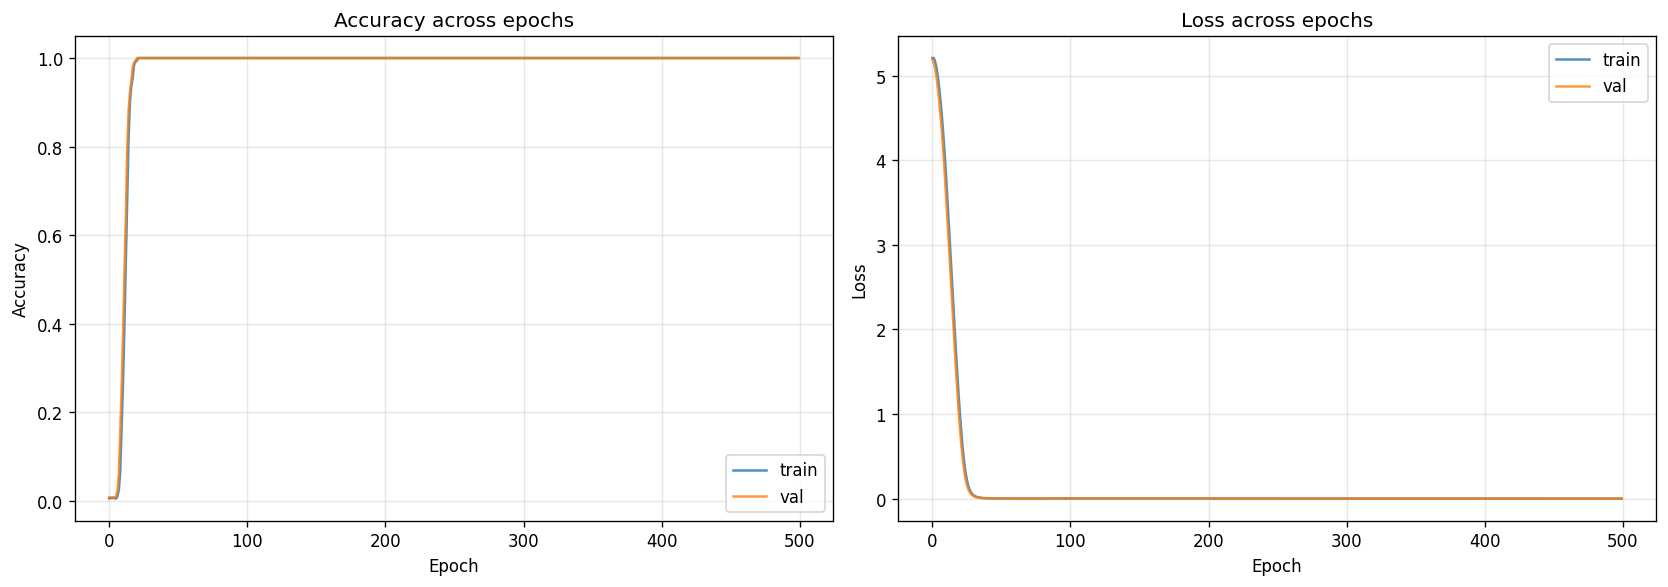

Final train acc: 1.0000  |  Final val acc: 1.0000
Final train loss: 0.0000  |  Final val loss: 0.0000


In [57]:
import re

log_path = os.path.join(RUN_PATH, "run.log")

train_epochs, train_loss, train_acc = [], [], []
val_epochs, val_loss, val_acc = [], [], []

train_re = re.compile(r"Epoch (\d+) \| train_loss=([\d.]+) \| train_acc=([\d.]+)")
val_re = re.compile(r"val_loss=([\d.]+) \| val_acc=([\d.]+)")

with open(log_path) as f:
    epoch_counter = -1
    for line in f:
        m = train_re.search(line)
        if m:
            epoch_counter = int(m.group(1))
            train_epochs.append(epoch_counter)
            train_loss.append(float(m.group(2)))
            train_acc.append(float(m.group(3)))
            continue
        m = val_re.search(line)
        if m:
            val_epochs.append(epoch_counter + 1 if epoch_counter >= 0 else 0)
            val_loss.append(float(m.group(1)))
            val_acc.append(float(m.group(2)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_epochs, train_acc, label="train", alpha=0.8)
ax1.plot(val_epochs, val_acc, label="val", alpha=0.8)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy across epochs")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_epochs, train_loss, label="train", alpha=0.8)
ax2.plot(val_epochs, val_loss, label="val", alpha=0.8)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Loss across epochs")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final train acc: {train_acc[-1]:.4f}  |  Final val acc: {val_acc[-1]:.4f}")
print(f"Final train loss: {train_loss[-1]:.4f}  |  Final val loss: {val_loss[-1]:.4f}")

In [28]:
# Build vocab and dataset


vocab = build_shared_vocab(data_cfg.modulus)

val_ds = FullModularAdditionDataset(
    vocab=vocab, cfg=data_cfg, frac_train=0.3, split="val", seed=0, 
)
print(f"Val set size: {len(val_ds)} pairs")

# Grab a small batch for interp
N = 256
batch_items = [val_ds[i] for i in range(N)]
batch = causal_lm_collate(batch_items, pad_id=vocab.pad_id)
input_ids = batch["input_ids"].to(DEVICE)
target_ids = batch["target_ids"].to(DEVICE)

# Show a few examples
for i in range(5):
    toks = vocab.decode(input_ids[i].tolist())
    true_answer = (int(toks[0]) + int(toks[1])) % data_cfg.modulus
    match = int(toks[-1]) == true_answer
    print(" ".join(toks), '...', match)

Val set size: 8939 pairs
50 67 = 4 ... True
92 107 = 86 ... True
29 14 = 43 ... True
76 53 = 16 ... True
78 80 = 45 ... True


## 2. Attention patterns

Visualize what tokens each head attends to. In modular addition, we expect
heads that attend to the operand positions (the digits before `+` and `=`).

In [29]:
# Run a single example and cache attention patterns
example_ids = input_ids[:1]  # single example
logits, cache = model.run_with_cache(
    example_ids,
    names_filter=lambda n: "attn_pattern" in n,
)

# Get token labels for axes
tokens = vocab.decode(example_ids[0].tolist())
print(f"Input: {' '.join(tokens)}")
print(f"Available hooks: {[n for n in model.hook_dict if 'attn_pattern' in n]}")

Input: 50 67 = 4
Available hooks: ['blocks.0.attn.hook_attn_pattern']


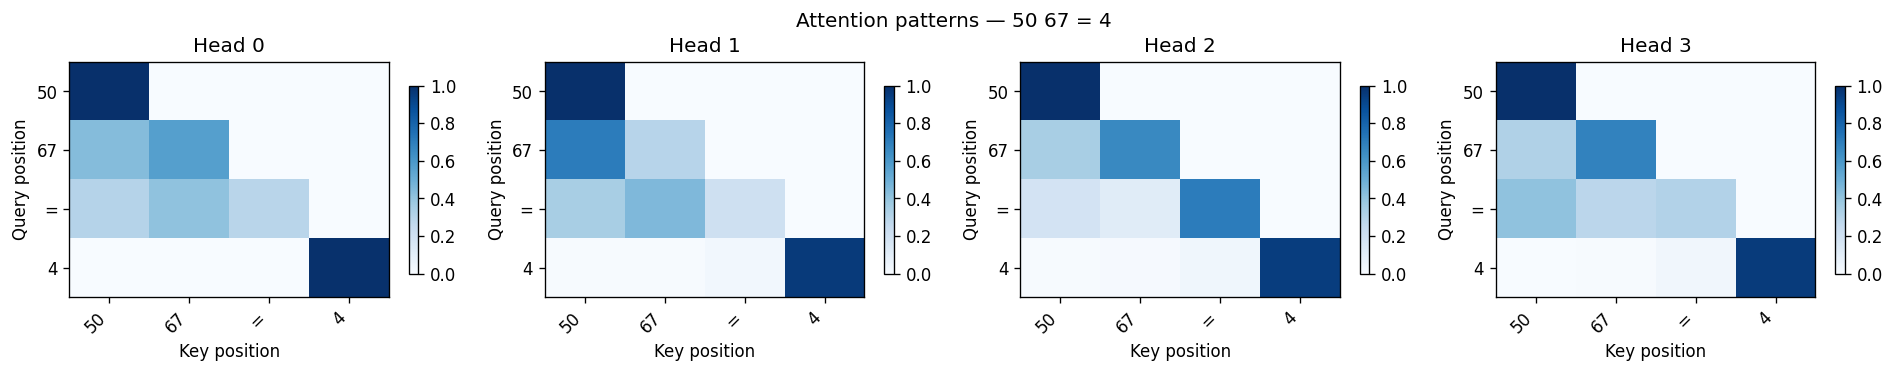

In [30]:
# Plot all heads in layer 0
attn = cache["blocks.0.attn.hook_attn_pattern"]  # (1, n_heads, T, T)
attn_np = attn[0].detach().cpu().float().numpy()  # (n_heads, T, T)

fig = plot_attention_heads(attn_np, tokens=tokens)
fig.suptitle(f"Attention patterns — {' '.join(tokens)}", y=1.02)
plt.show()

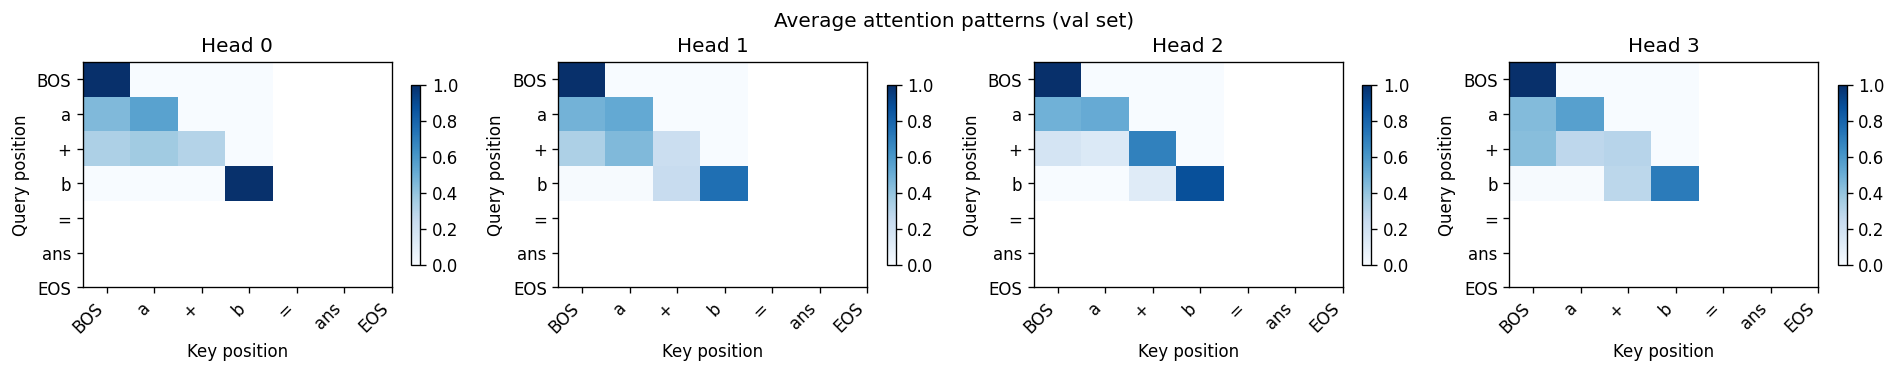

In [31]:
# Average attention patterns across the val batch
logits_batch, cache_batch = model.run_with_cache(
    input_ids,
    names_filter=lambda n: "attn_pattern" in n,
)

avg_attn = cache_batch["blocks.0.attn.hook_attn_pattern"].mean(dim=0)  # (n_heads, T, T)
avg_attn_np = avg_attn.detach().cpu().float().numpy()

# Use positional labels since tokens vary across batch
pos_labels = ["BOS", "a", "+", "b", "=", "ans", "EOS"]
fig = plot_attention_heads(avg_attn_np, tokens=pos_labels)
fig.suptitle("Average attention patterns (val set)", y=1.02)
plt.show()

## 3. Residual stream activations

Look at how the residual stream norms evolve across positions.
In a model that has learned modular addition, we expect the representation
at the `=` position to carry the most information.

In [33]:
# Cache residual stream activations
_, cache_resid = model.run_with_cache(
    input_ids,
    names_filter=lambda n: "resid" in n,
)

print("Residual stream hooks:")
for name in sorted(cache_resid.keys()):
    shape = cache_resid[name].shape
    print(f"  {name}: {shape}")

Residual stream hooks:
  blocks.0.hook_resid_mid: torch.Size([256, 4, 128])
  blocks.0.hook_resid_post: torch.Size([256, 4, 128])
  blocks.0.hook_resid_pre: torch.Size([256, 4, 128])
  hook_resid_final: torch.Size([256, 4, 128])


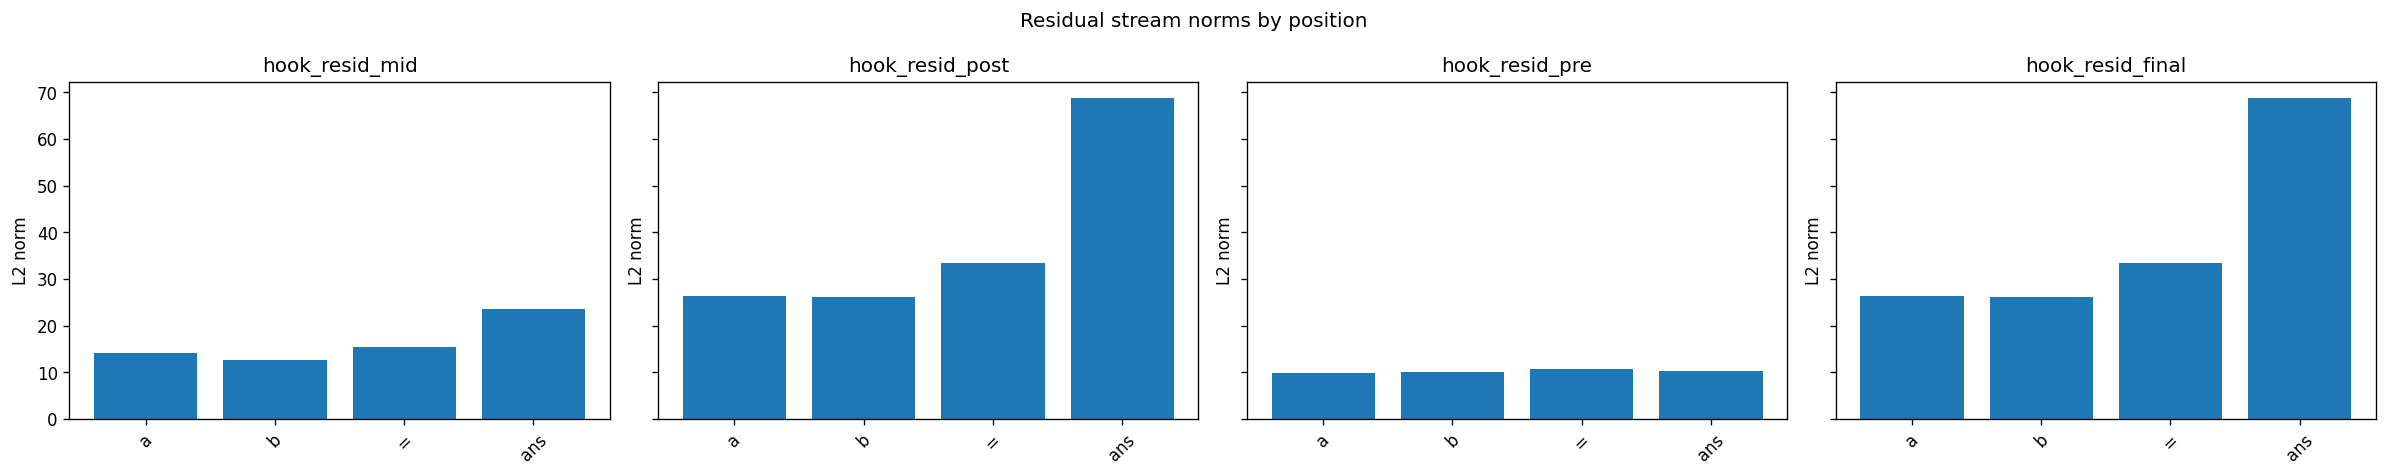

In [37]:
# Plot residual stream norms at each position, averaged over the batch
fig, axes = plt.subplots(1, len(cache_resid), figsize=(5 * len(cache_resid), 4), sharey=True)
if not hasattr(axes, "__len__"):
    axes = [axes]

for ax, (name, act) in zip(axes, sorted(cache_resid.items())):
    # act shape: (B, T, d_model)
    norms = act.float().norm(dim=-1).mean(dim=0).detach().cpu().numpy()  # (T,)
    ax.bar(range(len(norms)), norms)
    ax.set_xticks(range(len(pos_labels)))
    ax.set_xticklabels(pos_labels, rotation=45)
    ax.set_title(name.split(".")[-1])
    ax.set_ylabel("L2 norm")

fig.suptitle("Residual stream norms by position")
plt.tight_layout()
plt.show()

## 4. Ablation study

Which attention heads are important for getting the right answer?
We zero-ablate each head and measure the change in loss at the answer position.

blocks.0.attn.hook_z:head_3               baseline=0.0000  ablated=0.0070  delta=+0.0070
blocks.0.attn.hook_z:head_1               baseline=0.0000  ablated=0.0041  delta=+0.0040
blocks.0.attn.hook_z:head_2               baseline=0.0000  ablated=0.0032  delta=+0.0031
blocks.0.attn.hook_z:head_0               baseline=0.0000  ablated=0.0011  delta=+0.0011


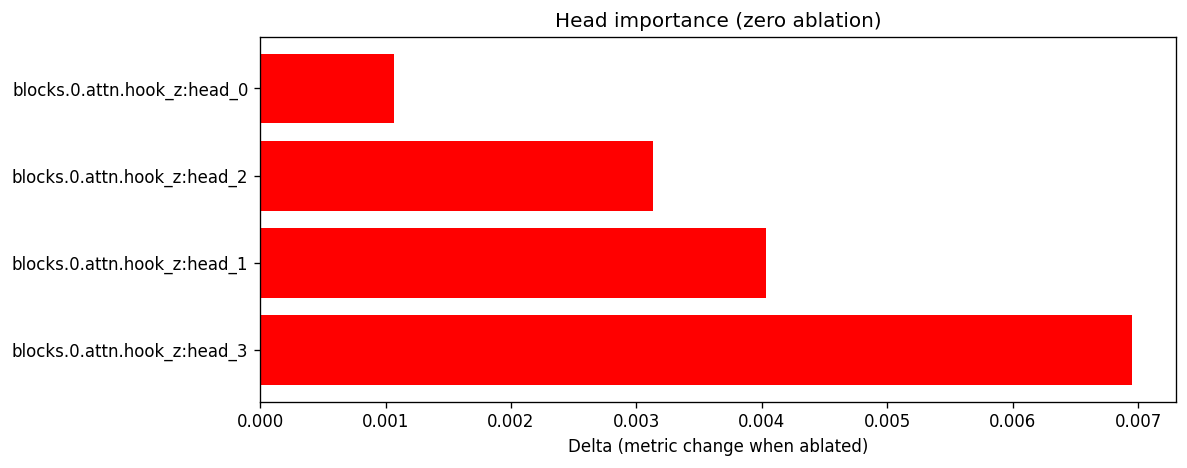

In [45]:
# Define a metric: cross-entropy loss at the answer position
import torch.nn.functional as F

def answer_loss(logits: torch.Tensor) -> float:
    """CE loss at the supervised (answer) position, averaged over batch."""
    mask = target_ids != -100
    loss = F.cross_entropy(
        logits.view(-1, logits.size(-1)),
        target_ids.view(-1),
        ignore_index=-100,
    )
    return loss.item()

# Run ablation sweep over all heads
results = head_ablation_sweep(
    model, input_ids, answer_loss, ablation_type="zero",
)

for r in results:
    print(f"{r.component:40s}  baseline={r.baseline_metric:.4f}  ablated={r.ablated_metric:.4f}  delta={r.delta:+.4f}")

ax = plot_ablation_results(results, title="Head importance (zero ablation)")
plt.show()

## 5. Fourier analysis of embeddings

A key finding from Nanda et al.: the model represents numbers using
Fourier components of the modular group. We check whether the digit
embeddings have structure in the DFT domain.

Digit embeddings shape: (113, 128)


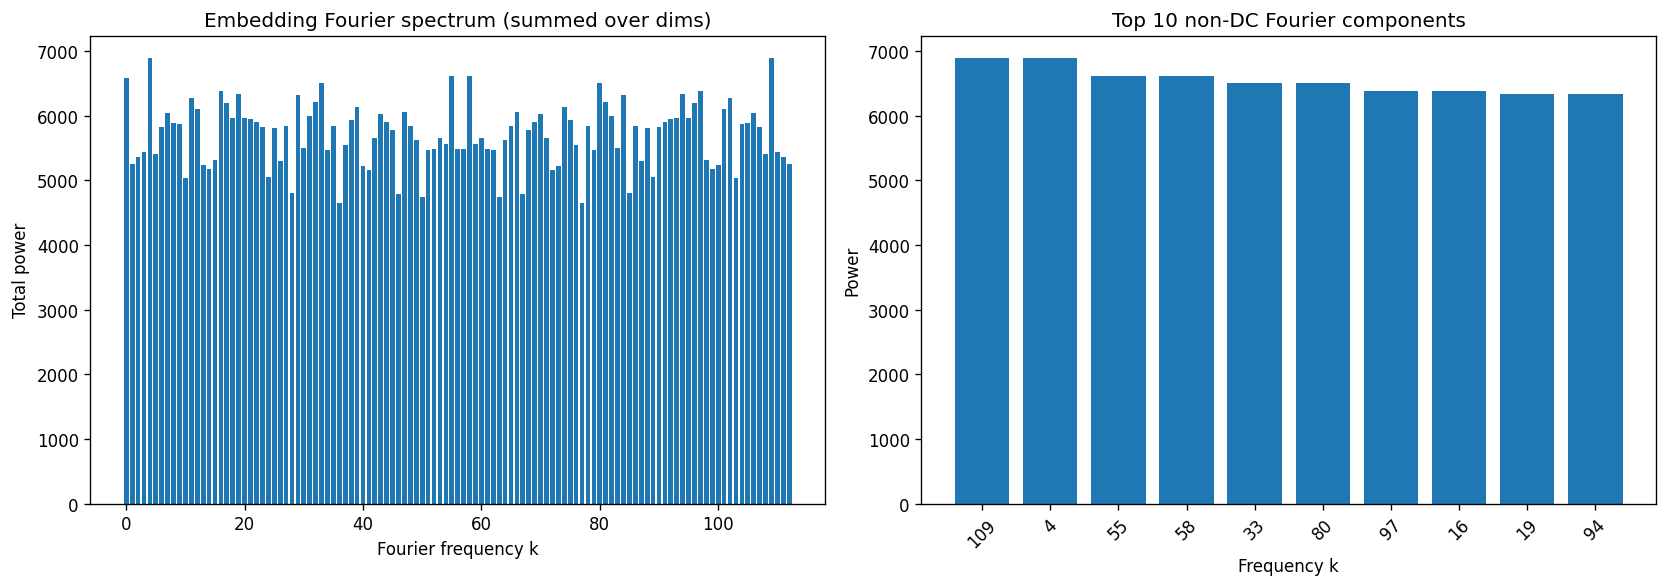


Top frequencies: [109, 4, 55, 58, 33, 80, 97, 16, 19, 94]
DC power fraction: 1.02%


In [46]:
# Extract digit embeddings (token ids for "0" through "p-1")
digit_ids = [vocab.token_to_id[str(i)] for i in range(MODULUS)]
digit_embeds = model.embed_tokens.weight[digit_ids].detach().cpu().float().numpy()  # (p, d_model)

print(f"Digit embeddings shape: {digit_embeds.shape}")

# Compute DFT along the digit axis for each embedding dimension
# Each column of digit_embeds is a function f: Z_p -> R
# Its DFT reveals which Fourier frequencies the model uses.
dft = np.fft.fft(digit_embeds, axis=0)  # (p, d_model)
dft_power = np.abs(dft) ** 2  # power spectrum

# Sum power across embedding dimensions for each frequency
freq_power = dft_power.sum(axis=1)  # (p,)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot total power per frequency
freqs = np.arange(MODULUS)
ax1.bar(freqs, freq_power)
ax1.set_xlabel("Fourier frequency k")
ax1.set_ylabel("Total power")
ax1.set_title("Embedding Fourier spectrum (summed over dims)")

# Highlight the top frequencies
# Skip DC component (k=0)
top_k = 10
# Use only non-DC frequencies, handle conjugate symmetry
half = MODULUS // 2
non_dc_power = freq_power.copy()
non_dc_power[0] = 0
top_freqs = np.argsort(non_dc_power)[-top_k:][::-1]

ax2.bar(range(top_k), non_dc_power[top_freqs])
ax2.set_xticks(range(top_k))
ax2.set_xticklabels([str(f) for f in top_freqs], rotation=45)
ax2.set_xlabel("Frequency k")
ax2.set_ylabel("Power")
ax2.set_title(f"Top {top_k} non-DC Fourier components")

plt.tight_layout()
plt.show()

print(f"\nTop frequencies: {top_freqs.tolist()}")
print(f"DC power fraction: {freq_power[0] / freq_power.sum():.2%}")

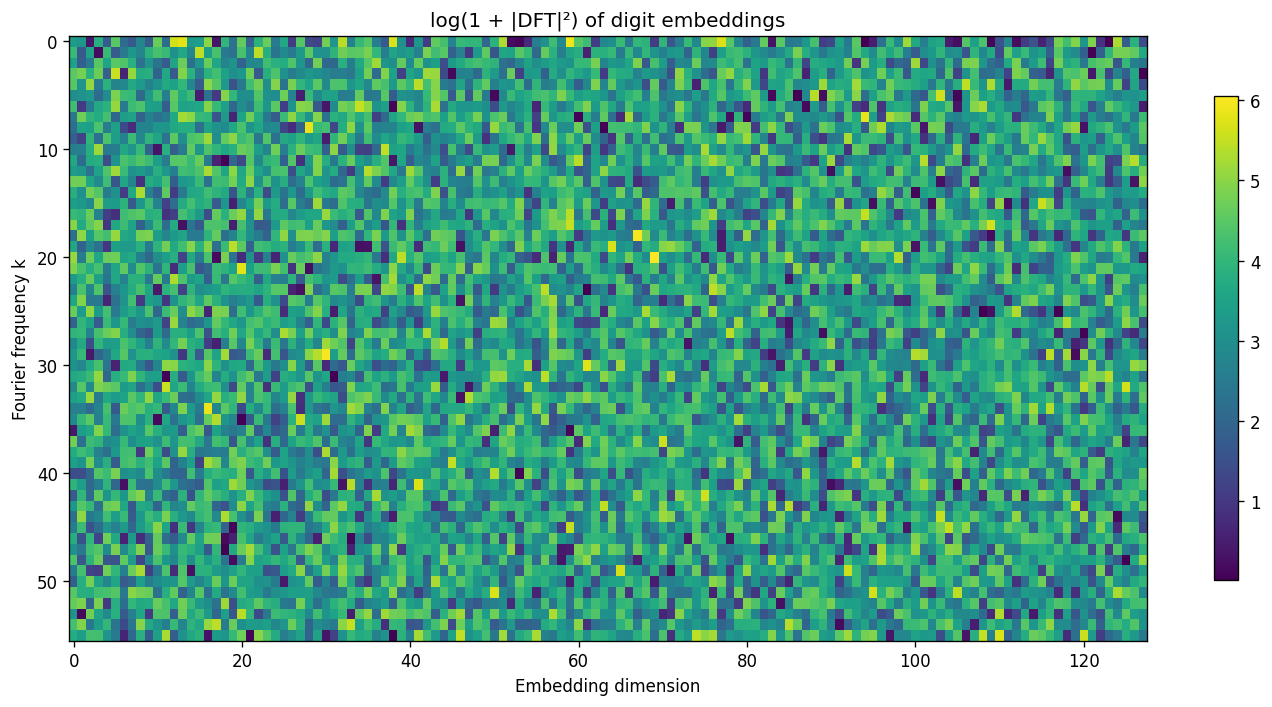

In [47]:
# Visualize the full DFT power heatmap (frequency x embedding dim)
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(
    np.log1p(dft_power[:half, :]),
    aspect="auto", cmap="viridis",
)
ax.set_xlabel("Embedding dimension")
ax.set_ylabel("Fourier frequency k")
ax.set_title("log(1 + |DFT|²) of digit embeddings")
fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()

## 6. Linear probing

Can we decode the answer `(a + b) mod p` from the residual stream
at various positions? This tells us *where* in the sequence the model
has computed the answer.

In [48]:
# Cache the final residual stream for the full batch
_, cache_probe = model.run_with_cache(
    input_ids,
    names_filter=["blocks.0.hook_resid_post"],
)

resid = cache_probe["blocks.0.hook_resid_post"]  # (B, T, d_model)

# Extract answer labels from the dataset
# For each example, answer = (a + b) % p. We can read it from target_ids.
# The supervised position has the answer token id.
answer_mask = target_ids != -100  # (B, T)
answer_token_ids = target_ids.clone()
answer_token_ids[~answer_mask] = 0
answer_labels = answer_token_ids.sum(dim=1)  # each row has exactly one non-(-100) value

# Convert token ids to digit values: token_id - offset
digit_offset = vocab.token_to_id["0"]
answer_digits = (answer_labels - digit_offset).long()

print(f"Residual shape: {resid.shape}")
print(f"Answer digits (first 10): {answer_digits[:10].tolist()}")
print(f"Unique classes: {answer_digits.unique().numel()}")

Residual shape: torch.Size([256, 4, 128])
Answer digits (first 10): [4, 86, 43, 16, 45, 22, 98, 98, 55, 78]
Unique classes: 100


In [51]:
# Probe at each token position
# pos_labels = ["BOS", "a", "+", "b", "=", "ans", "EOS"]
T = resid.shape[1]

# Split into probe train/val
split = N // 2
probe_results = {}

for pos in range(T):
    acts = resid[:, pos, :]  # (B, d_model)
    result = train_probe(
        activations=acts[:split],
        labels=answer_digits[:split],
        val_activations=acts[split:],
        val_labels=answer_digits[split:],
        probe_type="classification",
        epochs=200,
        lr=1e-2,
    )
    label = pos_labels[pos] if pos < len(pos_labels) else str(pos)
    probe_results[label] = result
    print(f"  pos={label:4s}  train_acc={result.train_accuracy:.3f}  val_acc={result.val_accuracy:.3f}")

  pos=a     train_acc=0.602  val_acc=0.008
  pos=b     train_acc=1.000  val_acc=0.000
  pos==     train_acc=1.000  val_acc=0.008
  pos=ans   train_acc=1.000  val_acc=0.680


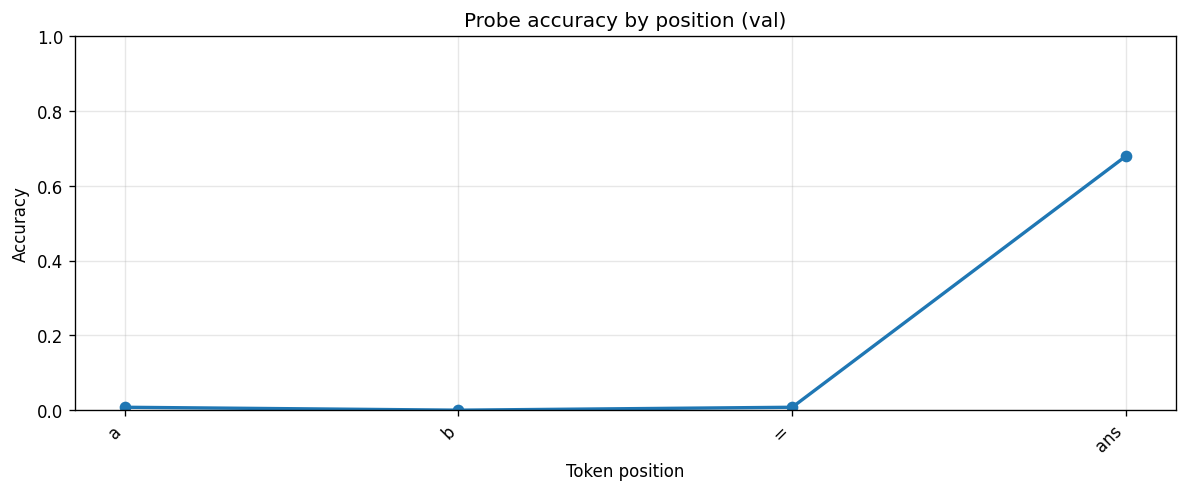

In [52]:
# Plot probe accuracy by position
from project.interp.viz import plot_probe_accuracy_by_layer

layer_accs = {name: r.val_accuracy for name, r in probe_results.items()}
ax = plot_probe_accuracy_by_layer(layer_accs, title="Probe accuracy by position (val)")
ax.set_xlabel("Token position")
plt.show()

## Next steps

- **Train longer** to observe grokking: `trainer.max_epochs=2000` and watch val_acc jump
- **Activation patching**: use `activation_patching()` to trace which positions causally matter
- **Logit lens**: project residual stream states through the unembedding to see intermediate "predictions"
- **Compare checkpoints**: load early (memorized) vs late (generalized) checkpoints and compare Fourier structure